In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import scipy as sp
import pickle 
import random
import math 
from scipy import optimize as opt
from astropy.io import fits
from astropy.table import Table, Column, vstack, hstack
import pyarrow.parquet as pq
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates import BarycentricMeanEcliptic

from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
import healpy as hp

In [17]:
### Functions

def Gaussian(x, A, sig, x0):
    g = A * np.exp(-(x-x0)**2 / (2*sig**2))
    return g


# Deep Field Selection

__Goal__: color-magnitude cut that goes deeper selecting sources to be photometered, utilizing deep field sentivitiy. While going deeper, we need to keep confusion under control.

__Considerations__: 
* Confusion from photometered sources
* Confusion from sub-threshold sources
* Varying sensitivity with ecliptic latitude

__Simulations__:
* Isolated Tractor photometry + Photoz on a small sample of sources placed at varying ecliptic latitude / NEP
    * Generate color-mag plot with redshift errors
    * Identify some 'contour' cuts 
* Blended Tractor photometry + Photoz: on everything (primary source and nearby bright sources to photometer, plus sub-threshold sources), multiple runs with varying color-magnitude selection cuts from the first simulation.
    * COSMOS sources placed at SPHEREx RC RA, DEC in a small region near NEP; 
    * or, Jordan's simulated catalog and SEDs.
    





##   Deep field coordinates using jean's data

In [2]:
## reduce nmc to 50 
file = "../../../../source_selection/data/obs_per_ecliptic_lat_R3.fits"
# file = "../../../../source_selection/data/spherex_hit_map_84.0_90.0_nside512.fits"

with fits.open(file) as hdul:
    print(len(hdul))
    print(hdul[1].header)
    data = hdul[1].data

with fits.open('../../../../SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits') as fits_data:
    cosmos = Table(fits_data[1].data)
    
## The cosmology reference catalog
cosmos_rc = "../../../../source_selection/COSMOS2020_SPHEXrefcat_v0.6_166k_withredshift_gemma_JAN2025.csv"
cosmos_rc = Table.read(cosmos_rc)


2
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   24 / length of dimension 1                          NAXIS2  =                  167 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    3 / number of table fields                         TTYPE1  = 'ecliptic_lat'                                                        TFORM1  = 'D       '                                                            TTYPE2  = 'observations'                                                        TFORM2  = 'D       '                                                            TTYPE3  = 'std     '                  

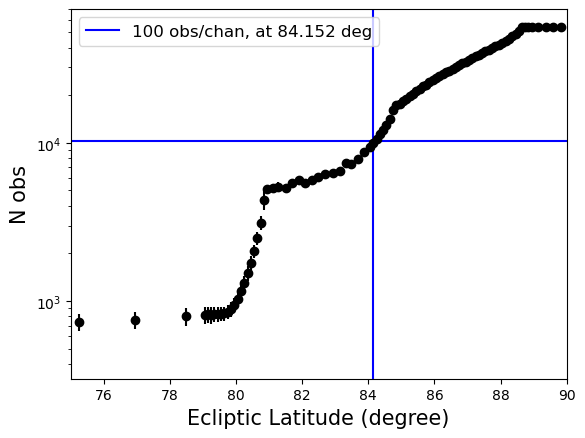

In [3]:
plt.errorbar(data['ecliptic_lat'], data['observations'], yerr=data['std'], fmt='o', color='black')
plt.yscale("log")
plt.xlim(75, 90)
plt.xlabel("Ecliptic Latitude (degree)", fontsize=15)
plt.ylabel("N obs", fontsize=15)

# find E.lat where 100 obs / chan
idx = np.where(abs(data['observations']-(102*100)) == (abs(data['observations']-(102*100))).min())[0][0]

plt.axhline(100*102, color='blue')
plt.axvline(data['ecliptic_lat'][idx], label=f"100 obs/chan, at {data['ecliptic_lat'][idx]:.3f} deg", color='blue')
plt.legend(fontsize=12)

RA, DEC for the 100 obs / channel is  284.4404263395492 65.88209300691376
number of sources in the cosmology flag, in the selected region =  1031


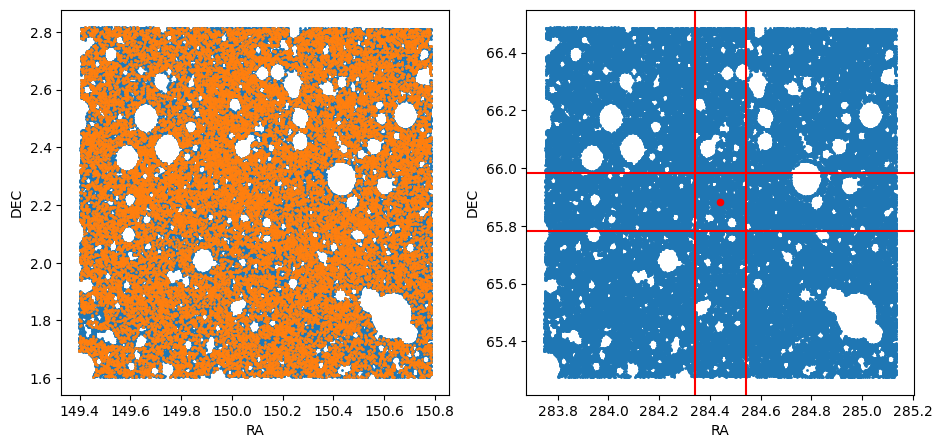

In [4]:
## find coordinates to do photometry at, convert to RA, DEC
elat = data['ecliptic_lat'][idx]
elon = 0 * u.deg # deg
crd = SkyCoord(elon, elat * u.deg, frame=BarycentricMeanEcliptic)  # NEP at (lon=0, lat=90)
ra0 = crd.transform_to('icrs').ra.deg
dec0 = crd.transform_to('icrs').dec.deg
print('RA, DEC for the 100 obs / channel is ', ra0, dec0)

## transform COSMOS field center to deep field
ra_c = (cosmos['ALPHA_J2000'].max() - cosmos['ALPHA_J2000'].min()) / 2 + cosmos['ALPHA_J2000'].min()
dec_c = (cosmos['DELTA_J2000'].max() - cosmos['DELTA_J2000'].min()) / 2 + cosmos['DELTA_J2000'].min()
if "ra_deep" not in cosmos.colnames:
    cosmos.add_column((cosmos['ALPHA_J2000'].copy() + (ra0 - ra_c)), name="ra_deep")
    cosmos.add_column((cosmos['DELTA_J2000'].copy() + (dec0 - dec_c)), name="dec_deep")

plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.scatter(cosmos['ALPHA_J2000'], cosmos['DELTA_J2000'], s=1)
flag_cosmology = cosmos_rc['COSMOLOGY']==1
plt.scatter(cosmos['ALPHA_J2000'][flag_cosmology], cosmos['DELTA_J2000'][flag_cosmology], s=1)
plt.xlabel("RA")
plt.ylabel("DEC")

plt.subplot(1,2,2)
plt.scatter(cosmos['ra_deep'], cosmos['dec_deep'], s=1)
plt.scatter(ra0, dec0, color='red', s=20)

## select a subsample surrounding the chosen coordinate pair
ra_min = ra0 - 0.1
ra_max = ra0 + 0.1
dec_min = dec0 - 0.1
dec_max = dec0 + 0.1
plt.axvline(ra_min, color='red')
plt.axvline(ra_max, color='red')
plt.axhline(dec_min, color='red')
plt.axhline(dec_max, color='red')

## count number of cosmology sources in the patch
flag_sub = (cosmos['ra_deep']>=ra_min) & \
           (cosmos['ra_deep']<=ra_max) & \
           (cosmos['dec_deep']>=dec_min) & \
           (cosmos['dec_deep']<=dec_max)
N_srcs_to_phot = len(np.where(flag_sub & flag_cosmology)[0])
print("number of sources in the cosmology flag, in the selected region = ", N_srcs_to_phot)

plt.xlabel("RA")
plt.ylabel("DEC")
plt.show()

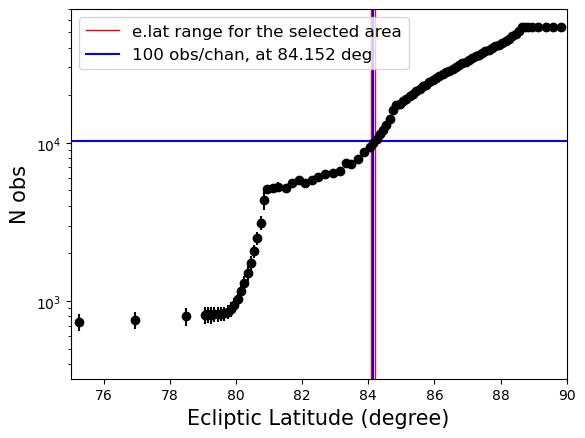

In [5]:
## convert the chosen region to ecliptic coordinates and compute the N obs variation
crds_chosen = SkyCoord(ra = (cosmos['ra_deep'][flag_cosmology & flag_sub]-0.) * u.deg,
                       dec = (cosmos['dec_deep'][flag_cosmology & flag_sub]-0.) * u.deg, 
                       frame='icrs')
crds_chosen_eclp = crds_chosen.transform_to(BarycentricMeanEcliptic)
plt.errorbar(data['ecliptic_lat'], data['observations'], yerr=data['std'], fmt='o', color='black')
plt.axvline(crds_chosen_eclp.lat.deg.max(), color='red', lw=1)
plt.axvline(crds_chosen_eclp.lat.deg.min(), color='red', lw=1, label='e.lat range for the selected area')

plt.yscale("log")
plt.xlim(75, 90)
plt.xlabel("Ecliptic Latitude (degree)", fontsize=15)
plt.ylabel("N obs", fontsize=15)
plt.axhline(100*102, color='blue')
plt.axvline(data['ecliptic_lat'][idx], label=f"100 obs/chan, at {data['ecliptic_lat'][idx]:.3f} deg", color='blue')
plt.legend(fontsize=12)

In [119]:

with fits.open("../../../hires_sed_COSMOS_0_60000_new010925_nolines_gemma.fits") as catalog:
    print(len(catalog))
    ii= 30000
    print(catalog[ii].header)
    spectrum = Table(
                    [
                        catalog[ii].data['wavelength'],
                        catalog[ii].data['sed_flux_mJy'],
                    ],
                    names=('lambda', 'FLUX'),
                )

60001
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   16 / length of dimension 1                          NAXIS2  =                 1105 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    2 / number of table fields                         TTYPE1  = 'wavelength'                                                          TFORM1  = 'D       '                                                            TTYPE2  = 'sed_flux_mJy'                                                        TFORM2  = 'D       '                                                            EXTNAME = '180634  '              

# Redshift Validation of Confusion


## QuickCatalog run on isolated COSMOS 32k

In [18]:

import sys
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, hstack
from astropy.io import fits
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates import BarycentricMeanEcliptic
import itertools
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import time 
import argparse
import os

import SPHEREx_ObsSimulator as SPobs
from SPHEREx_Simulator_Tools import data_filename
import SPHEREx_InstrumentSimulator as SPinst
from spherex_parameters import load_spherex_parameters
import SPHEREx_SkySimulator as SPsky
from SPHEREx_SkySimulator import QuickCatalog
from SPHEREx_SkySimulator import Catalog_to_Simulate

survey_plan_file = data_filename('spherex_survey_plan_R2.fits')
SPHEREx_Pointings = SPobs.Pointings(input_file=survey_plan_file, 
                                        Gaussian_jitter = 0.0, roll_angle='psi2')
# Load instrument and project parameters as a dictionary
spherex_parameters = load_spherex_parameters()
Scene = SPsky.Scene(SPHEREx_Pointings,
                        zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())

Channels = Table.read(data_filename('Channel_Definition_03022021.fits'))
# Instrument (no noise - get rid of noise_model and dark_current_model --> dark current, read noise, photon noise, zodi = 0)
trim = 32
ds = 4
SPHEREx_Instrument = SPinst.Instrument(
    instrument_data=spherex_parameters,
    psf=data_filename("psf/simulated_PSF_database_centered_v3_og.fits"),
    psf_downsample_by_array={1: ds, 2: ds, 3: ds, 4: ds, 5: ds, 6: ds},
    psf_trim_by_array={1: trim, 2: trim, 3: trim, 4: trim, 5: trim, 6: trim},
    noise_model=SPinst.white_noise,
    dark_current_model=SPinst.poisson_dark_current,
    lvf_model=SPinst.Tabular_Bandpass()
)

##--------- functions -------------
# function finding the new, corrected fits file
def find_sed_fits_file_corrected(index, tractorID):
    if index < 60000:
        #print("0 - 60000")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/0_60000/"
    elif index < 120000:
        #print("60000 - 120000")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/60000_120000/"
    else:
        #print("120000 - ")
        DIR = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/COSMOS_ALL_HIRES_SEDS_010925/120000_166041/"
    
    filename = DIR + f"cosmos2020_hiresSED_FarmerID_{tractorID:07d}_corrected.fits"
    return filename


## Load COSMOS reference catalogs
COSMOS_tab = Table.read('/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits', format='fits')
# CUT_xmatch = np.loadtxt('../source_selection/final_cut_boolarray.txt', dtype=bool)
# COSMOS_tab = COSMOS_tab[CUT_xmatch]

# # idx_refcat = np.loadtxt("./newrefcat_bool_COSMOSzch1.txt", dtype=bool)
# idx_refcat = np.loadtxt("../source_selection/final_colormag_cut_boolarray_nov2024.txt", dtype=bool)
idx_refcat = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/source_selection/cosmos166k_posmatch_boolarray.txt", dtype=bool)


## Move COSMOS to the deep field
file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/source_selection/data/obs_per_ecliptic_lat_R3.fits"
with fits.open(file) as hdul:
    data = hdul[1].data

# find ecliptic latitude where Nobs ~ 100 / channel --> 102*100 obs in total
idx = np.where(abs(data['observations']-(102*100)) == (abs(data['observations']-(102*100))).min())[0][0]
elat = data['ecliptic_lat'][idx]
elon = 0 * u.deg # deg # longitude doesn't matter, assuming symmetric about NEP.
crd = SkyCoord(elon, elat * u.deg, frame=BarycentricMeanEcliptic)  # NEP at (lon=0, lat=90)
ra0 = crd.transform_to('icrs').ra.deg
dec0 = crd.transform_to('icrs').dec.deg
print('RA, DEC for the 100 obs / channel is ', ra0, dec0)

# move COSMOS centered around this calculated coordinate pair.
ra_c = (COSMOS_tab['ALPHA_J2000'].max() - COSMOS_tab['ALPHA_J2000'].min()) / 2 + COSMOS_tab['ALPHA_J2000'].min()
dec_c = (COSMOS_tab['DELTA_J2000'].max() - COSMOS_tab['DELTA_J2000'].min()) / 2 + COSMOS_tab['DELTA_J2000'].min()
if "ra_deep" not in COSMOS_tab.colnames:
    COSMOS_tab.add_column((COSMOS_tab['ALPHA_J2000'].copy() + (ra0 - ra_c)), name="ra_deep")
    COSMOS_tab.add_column((COSMOS_tab['DELTA_J2000'].copy() + (dec0 - dec_c)), name="dec_deep")

## select a subsample surrounding the chosen coordinate pair ~ 0.2 * 0.2 deg^2 area --> 1k refcat sources
ra_min = ra0 - 0.1
ra_max = ra0 + 0.1
dec_min = dec0 - 0.1
dec_max = dec0 + 0.1
## count number of cosmology sources in the patch
flag_sub = (COSMOS_tab['ra_deep']>=ra_min) & \
           (COSMOS_tab['ra_deep']<=ra_max) & \
           (COSMOS_tab['dec_deep']>=dec_min) & \
           (COSMOS_tab['dec_deep']<=dec_max)
print("Number of refcat sources in the selected area = ", len(COSMOS_tab[idx_refcat & flag_sub]))


## Isolated photometry
i = 3
tID_central = COSMOS_tab['Tractor_ID'][idx_refcat & flag_sub][i]
print("tID = ", tID_central)
ra = COSMOS_tab['ra_deep'][idx_refcat & flag_sub][i]
dec = COSMOS_tab['dec_deep'][idx_refcat & flag_sub][i]
# ra = ra_c
# dec = dec_c

central_sed_fn = find_sed_fits_file_corrected(COSMOS_tab['col1'][idx_refcat & flag_sub][i],
                                              COSMOS_tab['Tractor_ID'][idx_refcat & flag_sub][i])

# # start timing
# time_start = time.time()
# QC = QuickCatalog(SPHEREx_Pointings, SPHEREx_Instrument, Scene, Use_Tractor=False, spectral_channel_table=Channels,\
#                   #do_not_fit=source_name,\
#                   subpixel_offset_x=0, subpixel_offset_y=0)
# Sources_to_Simulate_close = Catalog_to_Simulate()

# print("filename = ", central_sed_fn)
# Sources_to_Simulate_close.load_single(name=f"Central tID {int(tID_central)}", 
#                                       ra=ra*u.deg, 
#                                       dec=dec*u.deg, 
#                                       inputpath=central_sed_fn)
# # run QuickCatalog
# SPHEREx_Catalog, Truth_Catalog= QC(Sources_to_Simulate_close)

# # collate output secondary photometry tables
# file_inter = '/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/secondary_phot_id{}.parq'.format(i) # intermediate parquet file saving primary photometry
#             # save secondary photometry
# this = SPHEREx_Catalog['SOURCE_ID']==f"Central tID {int(tID_central)}"
# SPsky.save_level3_secondary(SPHEREx_Catalog[this], 
#                             Channels, 
#                             SPHEREx_Instrument, 
#                             file_inter, 
#                             pointing_table=SPHEREx_Pointings.pointing_table, 
#                             fluxerr_from_weights=True)
# secondary_tbl = Table.read(file_inter, format="parquet")
# time_end = time.time()

# print("\nTime elapsed = ", time_end - time_start)





RA, DEC for the 100 obs / channel is  284.4404263395492 65.88209300691376
Number of refcat sources in the selected area =  1031
tID =  15214


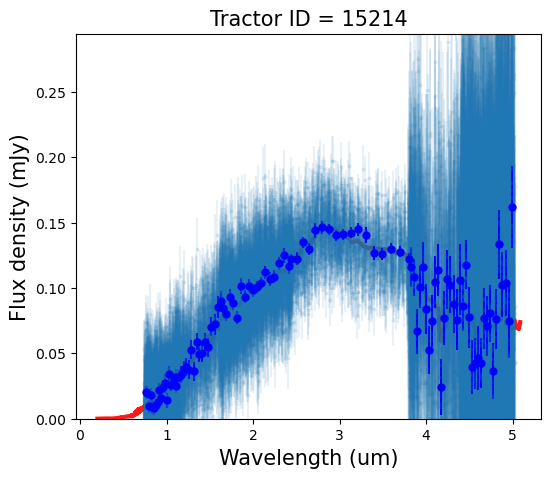

In [5]:
hires_sed = Table.read(central_sed_fn, format='fits')

fig = plt.figure(figsize=(6,5))
plt.plot(hires_sed['lambda'], hires_sed['FLUX'], color='red', lw=3, alpha=0.9, label='Input SED')
plt.errorbar(SPHEREx_Catalog[this]['WAVELENGTH'], SPHEREx_Catalog[this]['FLUX'], SPHEREx_Catalog[this]['FLUX_ERR'], 
             fmt='o', ms=2, alpha=0.1, label='primary')
plt.errorbar(secondary_tbl[0]['lambda'], secondary_tbl[0]['flux_allsky']/1000, yerr=secondary_tbl[0]['flux_err_allsky']/1000,
             fmt='o', ms=5, color='blue', label='secondary')
plt.ylim(0, hires_sed['FLUX'].max()*2)
plt.title(f"Tractor ID = {tID_central}", fontsize=15)
plt.xlabel("Wavelength (um)", fontsize=15)
plt.ylabel("Flux density (mJy)", fontsize=15)
plt.show()


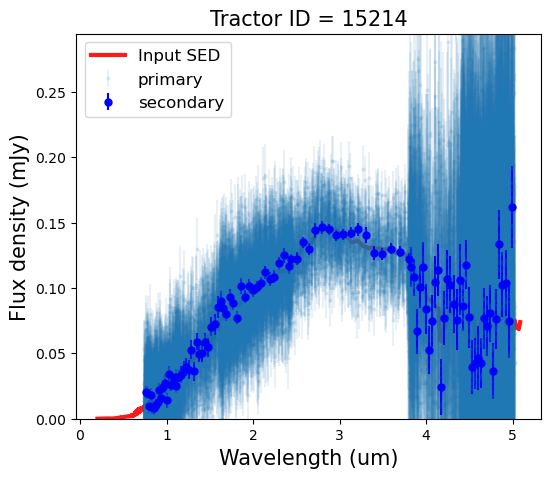

In [6]:

hires_sed = Table.read(central_sed_fn, format='fits')

fig = plt.figure(figsize=(6,5))
plt.plot(hires_sed['lambda'], hires_sed['FLUX'], color='red', lw=3, alpha=0.9, label='Input SED')
plt.errorbar(SPHEREx_Catalog[this]['WAVELENGTH'], SPHEREx_Catalog[this]['FLUX'], SPHEREx_Catalog[this]['FLUX_ERR'], 
             fmt='o', ms=2, alpha=0.1, label='primary')
plt.errorbar(secondary_tbl[0]['lambda'], secondary_tbl[0]['flux_allsky']/1000, yerr=secondary_tbl[0]['flux_err_allsky']/1000,
             fmt='o', ms=5, color='blue', label='secondary')
plt.ylim(0, hires_sed['FLUX'].max()*2)
plt.title(f"Tractor ID = {tID_central}", fontsize=15)
plt.xlabel("Wavelength (um)", fontsize=15)
plt.ylabel("Flux density (mJy)", fontsize=15)
plt.legend(fontsize=12)
plt.show()


## Background Subtraction Bias in Tractor

In [383]:
i = 3

## shallow
ra = ra_c+0.3
dec = dec_c+0.3
## deep
# ra = COSMOS_tab['ra_deep'][idx_refcat & flag_sub][i]
# dec = COSMOS_tab['dec_deep'][idx_refcat & flag_sub][i]

## shallow
pos_x = 'ALPHA_J2000'
pos_y = 'DELTA_J2000'
## deep
# pos_x = 'ra_deep'
# pos_y = 'dec_deep'

size = 6.2 * 10 / 3600 # 10 pixel extent in deg
ra_l = ra - size / 2
ra_h = ra + size / 2
dec_l = dec - size /2 
dec_h = dec + size / 2
want = (COSMOS_tab[pos_x]<=ra_h) &\
    (COSMOS_tab[pos_x]>=ra_l) &\
    (COSMOS_tab[pos_y]<=dec_h) &\
    (COSMOS_tab[pos_y]>=dec_l)
# select all background sources within this area, do src_sub
want_id = np.where(want)[0]

# initialize arrays to hold true sub-threshold sources
bg_id = np.array([], dtype=int)
bg_tractor_id = np.array([], dtype=int)
for id in want_id:
    if idx_refcat[id] == False:
        bg_id = np.append(bg_id, id) # pre-id (index) among 166k catalog
        bg_tractor_id = np.append(bg_tractor_id, COSMOS_tab['Tractor_ID'][id])
print("   Number of nearby sub-threshold sources = ", len(bg_tractor_id)) 

# create a list of background source name
source_name = []
for name in bg_tractor_id:
    source_name.append("COSMOS2020_" + "{}".format(name).zfill(7))

# initiate QC with Tractor
time_start = time.time()
QC = QuickCatalog(SPHEREx_Pointings, SPHEREx_Instrument, Scene, \
                  Use_Tractor=True, spectral_channel_table=Channels,\
                  do_not_fit=source_name,\
                  return_fit=f"Central tID {int(tID_central)}",\
                  subpixel_offset_x=0, subpixel_offset_y=0)
Sources_to_Simulate_confusion = Catalog_to_Simulate()

Sources_to_Simulate_confusion.load_single(name=f"Central tID {int(tID_central)}", 
                                        ra=ra*u.deg, 
                                        dec=dec*u.deg, 
                                        inputpath=central_sed_fn)


# ## add in nearby background sources sed
for n in range(len(bg_tractor_id)):

    ra_sub = COSMOS_tab[pos_x][bg_id[n]]
    dec_sub = COSMOS_tab[pos_y][bg_id[n]]
    # print("\n")
    # print(bg_tractor_id[n], idx_refcat[bg_id[n]], '  ra=', ra_sub, '  dec=', dec_sub)

    filename = find_sed_fits_file_corrected(index=bg_id[n],
                                            tractorID=bg_tractor_id[n])
    # print(filename)

    Sources_to_Simulate_confusion.load_single(name=source_name[n],
                                            ra=ra_sub*u.deg,
                                            dec=dec_sub*u.deg,
                                            inputpath=filename)

# run QuickCatalog, return the best fit model for the primary source
SPHEREx_Catalog_confusion, Truth_Catalog_confusion, hdulist = QC(Sources_to_Simulate_confusion, nmc=50)
print("Done")

   Number of nearby sub-threshold sources =  30
Done


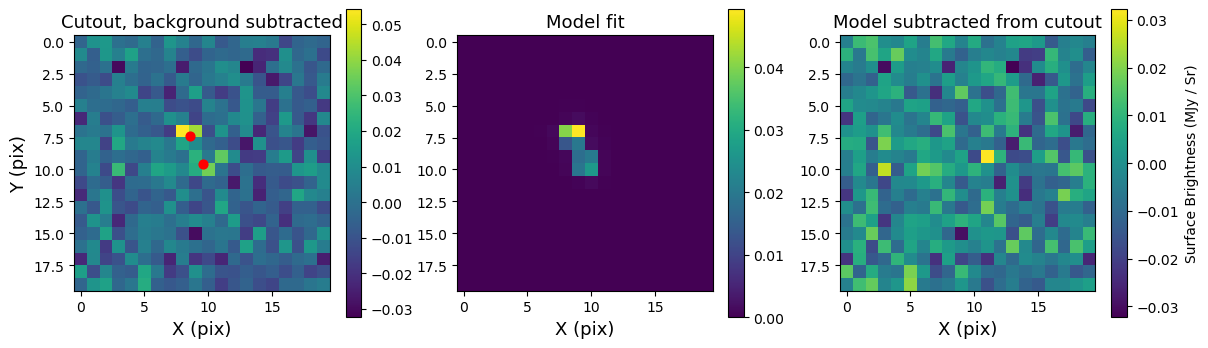

Text(0.5, 1.0, 'Surface Brightness Distribution for the Cutout Above')

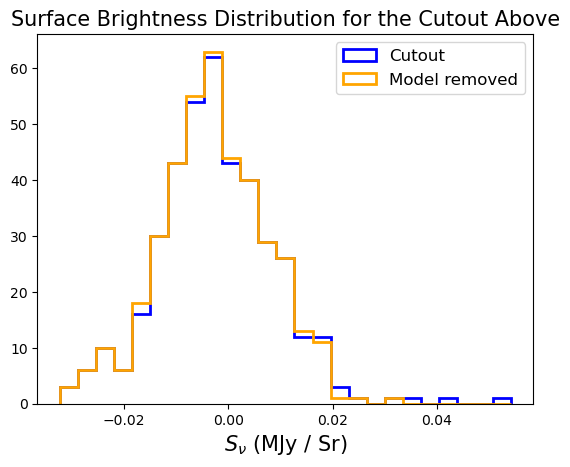

In [382]:
## hdul[0] - cutout; hdul[1] - model; hdul[2] - fit info
startidx = 243
# startidx = 243 + 3001 * 3
fig = plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.imshow(hdulist[startidx+0].data) # cutout
plt.colorbar()
plt.xlabel("X (pix)", fontsize=13)
plt.ylabel("Y (pix)", fontsize=13)

# primary source
plt.scatter(hdulist[startidx+2].data['X'][0], hdulist[startidx+2].data['Y'][0], color='red', s=40)
# sub-threshold sources
for s in range(1, len(hdulist[startidx+2].data)):
    plt.scatter(hdulist[startidx+2].data['X'][s], hdulist[startidx+2].data['Y'][s], color='yellow', s=10)

plt.title("Cutout, background subtracted", fontsize=13)

plt.subplot(1,3,2)
plt.imshow(hdulist[startidx+1].data) # model
plt.colorbar()
plt.xlabel("X (pix)", fontsize=13)
plt.title("Model fit", fontsize=13)

plt.subplot(1,3,3)
img_model_rmv = hdulist[startidx+0].data - hdulist[startidx+1].data
plt.imshow(img_model_rmv) # model
cbar = plt.colorbar()
cbar.set_label("Surface Brightness (MJy / Sr)")
plt.title("Model subtracted from cutout", fontsize=13)
plt.xlabel("X (pix)", fontsize=13)
plt.show()

## plot histogram of fluxes within this image (observation)
_, bins, _ = plt.hist(hdulist[startidx+0].data.flatten(), 
                      bins=25, histtype='step', label='Cutout', lw=2, color='blue');
plt.hist((img_model_rmv).flatten(), 
         bins=bins, histtype='step', label='Model removed', lw=2, color='orange');

plt.xlabel(r"$S_{\nu}$ (MJy / Sr)", fontsize=15)
plt.legend(fontsize=12)
plt.title("Surface Brightness Distribution for the Cutout Above", fontsize=15)


In [369]:
SPHEREx_Catalog_confusion['FLUX'][81], SPHEREx_Catalog_confusion['FLUX_ERR'][81]

(0.1301737451709448, 0.02308977803748285)

In [372]:
SPHEREx_Catalog_confusion['FLUX'][81], SPHEREx_Catalog_confusion['FLUX_ERR'][81]

(0.14784192933351345, 0.023112401225270227)

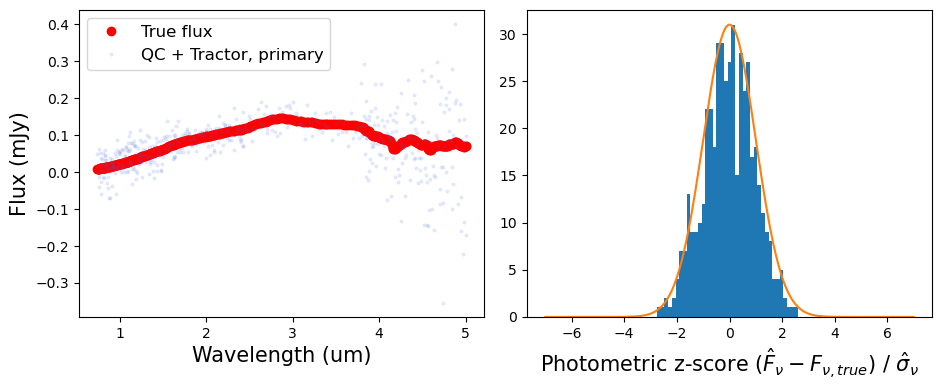

In [357]:
fig = plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
this = (SPHEREx_Catalog_confusion['SOURCE_ID'] == f"Central tID {int(tID_central)}")
plt.plot(SPHEREx_Catalog_confusion[this]['WAVELENGTH'], Truth_Catalog_confusion[this]['Flux'], 
         'o', color='red', label='True flux')
plt.plot(SPHEREx_Catalog_confusion[this]['WAVELENGTH'], SPHEREx_Catalog_confusion[this]['FLUX'], 
         'o', color='royalblue', ms=2, alpha=0.1, label='QC + Tractor, primary')
plt.xlabel("Wavelength (um)", fontsize=15)
plt.ylabel("Flux (mJy)", fontsize=15)
plt.legend(fontsize=12)

# photometric z-score
def Gaussian(x, A, sig, x0):
    g = A * np.exp(-(x-x0)**2 / (2*sig**2))
    return g

plt.subplot(1,3,2)
zsc = (SPHEREx_Catalog_confusion[this]['FLUX'] - Truth_Catalog_confusion[this]['Flux']) / SPHEREx_Catalog_confusion[this]['FLUX_ERR']
hist = plt.hist(zsc, bins=np.linspace(-7,7,100))[0]
zz = np.linspace(-7,7,300)
plt.plot(zz, Gaussian(zz, hist.max(), 1, 0))
plt.xlabel(r"Photometric z-score ($\hat{F}_{\nu} - F_{\nu, true}$) / $\hat{\sigma}_{\nu}$", fontsize=15)

fig.tight_layout()



6 13 6 13


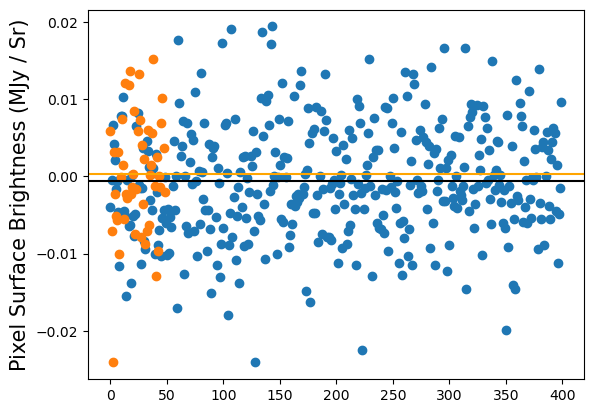

-0.0005958121761024092


In [8]:
sub_x_l = int(hdulist[startidx+2].data['X'][0] - 3)
sub_x_h = int(hdulist[startidx+2].data['X'][0] + 4)
sub_y_l = int(hdulist[startidx+2].data['Y'][0] - 3)
sub_y_h = int(hdulist[startidx+2].data['Y'][0] + 4)
print(sub_x_l, sub_x_h, sub_y_l, sub_y_h)

plt.plot(img_model_rmv.flatten(), 'o')
plt.plot(img_model_rmv[sub_y_l:sub_y_h, sub_x_l:sub_x_h].flatten(), 'o')
plt.axhline(np.mean(img_model_rmv), color='black')
plt.axhline(np.mean(img_model_rmv[sub_y_l:sub_y_h, sub_x_l:sub_x_h]), color='orange')

plt.ylabel("Pixel Surface Brightness (MJy / Sr)", fontsize=15)
plt.show()
print(np.mean(img_model_rmv))


## QC + Tractor with sub-threshold confusion, confusion_validation_deepfield.py

__confusion injection__:

Could inject confusion library into controlled, isolated QC deep field photometry;

Compare with such redshift results with Tractor on with confusion QC run. 

### check output

49671


(0.0, 70.0)

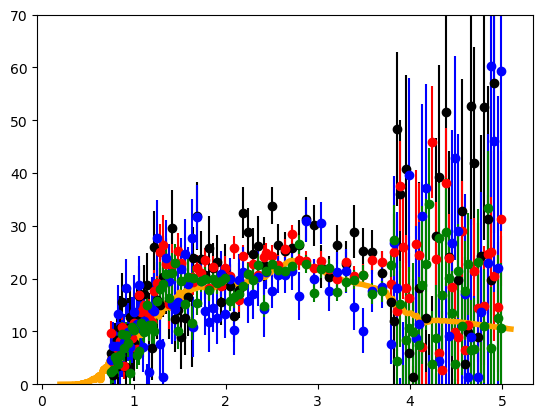

In [385]:

ii = 2101

dir_ = f"/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/secondary_phot_id{ii}.parq"
dir_ctrl = f"/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/secondary_phot_id{ii}_cntl.parq"

out_ = Table.read(dir_)
out_ctrl = Table.read(dir_ctrl)


plt.errorbar(out_['lambda'][0], out_['flux_allsky'][0], 
             yerr=out_['flux_err_allsky'][0], fmt='o', color='black')
plt.errorbar(out_['lambda'][0], out_['flux_deepfield'][0], 
             yerr=out_['flux_err_deepfield'][0], fmt='o', color='red')

plt.errorbar(out_ctrl['lambda'][0], out_ctrl['flux_allsky'][0], 
             yerr=out_ctrl['flux_err_allsky'][0], fmt='o', color='blue')
plt.errorbar(out_ctrl['lambda'][0], out_ctrl['flux_deepfield'][0], 
             yerr=out_ctrl['flux_err_deepfield'][0], fmt='o', color='green')

# match ra, dec, pull high resolution SED
index = np.where(np.isclose(out_['ra'],  COSMOS_tab['ra_deep'], rtol=1e-6) &\
                 np.isclose(out_['dec'], COSMOS_tab['dec_deep'], rtol=1e-6))[0][0]
print(index)
tractor_ID = COSMOS_tab['Tractor_ID'][index]
sed = Table.read(find_sed_fits_file_corrected(index, tractor_ID), format='fits')

plt.plot(sed['lambda'], sed['FLUX']*1000, color='orange', lw=4)
plt.ylim(0, 70)

### combine all parq files

In [87]:
def write_output(source_id, ra, dec, flux, flux_err, filename, NewFile=False):
    
    """
    In SPHEREx resolution (102 channels)
    flux and flux_err in mJy!!!
    """
    
    # write output .txt file
    spectrum = list(itertools.chain(*zip(flux, flux_err))) # in mJy
    # insert ID, ra, dec
    spectrum.insert(0, dec)
    spectrum.insert(0, ra)
    spectrum.insert(0, int(source_id))
    
    if NewFile == False:
        # open the existing file and append a line of spectrum. 
        with open(filename, "a") as f:
            f.write("\n" + " ".join(map(str, spectrum)))
            
    else:
        # create a new file and write the first line
        with open(filename, "w") as f:
            f.write(" ".join(map(str, spectrum)))
    
    return 


In [88]:
### COMBINE ALL PARQUET FILES
## find all primary photometry files!!!

directory = '/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/validation/'
name = 'secondary_phot' # files starting with 'primary' 
 
files = os.listdir(directory)
 
filenames = [filename for filename in files if filename.startswith(name)]

# split between experimental and controlled samples
files_exprt = [file for file in filenames if not file.endswith("cntl.parq")]
files_cntrl = [file for file in filenames if file.endswith("cntl.parq")]

# sort files based on ID number, ensuring two samples follow the same order
files_exprt_sorted = sorted(files_exprt, key=lambda x: int(x.split('id')[-1].split('.')[0]))
files_cntrl_sorted = sorted(files_cntrl, key=lambda x: int(x.split('id')[-1].split('_')[0]))
print(len(files_exprt_sorted), len(files_cntrl_sorted))

3018 3018


In [100]:
## experiment samples (no controlled), combine all into a single parquet table

output_name = "secondary_combined_redshift_valid1k_allsky.txt"
# output_name = "secondary_combined_redshift_valid1k_deepfield.txt"
remove = False

for i, file in enumerate(files_exprt_sorted):
    # experiment sample

    # read the primary photometry parquet table
    data = Table.read(directory+file)
    
    # match to tractor ID
    index = np.where(np.isclose(data['ra'],  COSMOS_tab['ra_deep'], rtol=1e-6) &\
                     np.isclose(data['dec'], COSMOS_tab['dec_deep'], rtol=1e-6))[0][0]
    tractor_ID = COSMOS_tab['Tractor_ID'][index]
    # print(tractor_ID)

    # write relevant columns to an output table fed into photo-z
    flux = data['flux_allsky'][0] / 1000 # mJy
    fluxerr = data['flux_err_allsky'][0] / 1000 # mJy

    
    if i==0:
        write_output(source_id=tractor_ID,
                     ra=data['ra'][0], 
                     dec=data['dec'][0],
                     flux=flux,
                     flux_err=fluxerr,
                     filename=directory+output_name,
                     NewFile=True)
    else:
        # if not the first source, append photometry to the first table.
        write_output(source_id=tractor_ID,
                     ra=data['ra'][0], 
                     dec=data['dec'][0],
                     flux=flux,
                     flux_err=fluxerr,
                     filename=directory+output_name,
                     NewFile=False)

    # if remove is True, remove individual primary parquet files
    if remove is True:
        # print("remove")
        os.remove(directory + file)
        


In [98]:
## experiment samples (no controlled), combine all into a single parquet table

# output_name = "secondary_combined_redshift_valid1k_allsky_cntl.txt"
output_name = "secondary_combined_redshift_valid1k_deepfield_cntl.txt"
remove = False

for i, file in enumerate(files_cntrl_sorted):
    # experiment sample

    # read the primary photometry parquet table
    data = Table.read(directory+file)
    
    # match to tractor ID
    index = np.where(np.isclose(data['ra'],  COSMOS_tab['ra_deep'], rtol=1e-6) &\
                     np.isclose(data['dec'], COSMOS_tab['dec_deep'], rtol=1e-6))[0][0]
    tractor_ID = COSMOS_tab['Tractor_ID'][index]
    # print(tractor_ID)

    # write relevant columns to an output table fed into photo-z
    flux = data['flux_deepfield'][0] / 1000 # mJy
    fluxerr = data['flux_err_deepfield'][0] / 1000 # mJy

    
    if i==0:
        write_output(source_id=tractor_ID,
                     ra=data['ra'][0], 
                     dec=data['dec'][0],
                     flux=flux,
                     flux_err=fluxerr,
                     filename=directory+output_name,
                     NewFile=True)
    else:
        # if not the first source, append photometry to the first table.
        write_output(source_id=tractor_ID,
                     ra=data['ra'][0], 
                     dec=data['dec'][0],
                     flux=flux,
                     flux_err=fluxerr,
                     filename=directory+output_name,
                     NewFile=False)

    # if remove is True, remove individual primary parquet files
    if remove is True:
        # print("remove")
        os.remove(directory + file)
        


In [109]:
dd = np.loadtxt(directory + "secondary_combined_redshift_valid1k_allsky_cntl.txt")

In [110]:
wl = Channels['lambda_min'] + (Channels['lambda_max'] - Channels['lambda_min']) / 2

<ErrorbarContainer object of 3 artists>

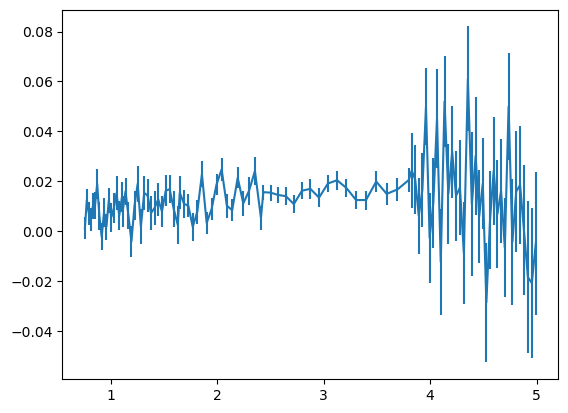

In [111]:
plt.errorbar(wl, dd[-1][3::2], yerr=dd[-1][4::2])

### Check photometric z-score

In [113]:
## read 102-band noiseless SED
sed102 = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/makegrid_photometry/makegrid_output/cosmos2020_166k_catgrid_102spherex.out")
print(sed102.shape)

## read 102-band noisy (allsky) photometry
phot_all = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/secondary_combined_redshift_valid1k_allsky.txt")
phot_all_cntl = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/secondary_combined_redshift_valid1k_allsky_cntl.txt")
phot_deep = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/secondary_combined_redshift_valid1k_deepfield.txt")
phot_deep_cntl = np.loadtxt("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/secondary_combined_redshift_valid1k_deepfield_cntl.txt")


(166041, 105)


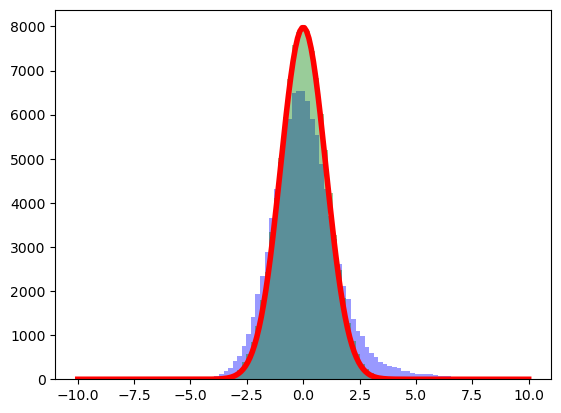

In [93]:
# for each photometry file (all-sky), compute z-score

zscores = []
zscores_cntl = []
for i in range(phot_all.shape[0]):
    
    # match tractor ID
    idx_match = np.where(COSMOS_tab['Tractor_ID']==phot_all[i][0])[0][0]
    
    zscore = (phot_all[i][3::2] - sed102[idx_match][3:] - 0.004) / phot_all[i][4::2]
    zscores.append(zscore)
    
    zscore_cntl = (phot_all_cntl[i][3::2] - sed102[idx_match][3:]) / phot_all_cntl[i][4::2]
    zscores_cntl.append(zscore_cntl)

zscores = np.array(zscores)
zscores_cntl = np.array(zscores_cntl)



hist = plt.hist(zscores.flatten(), bins=np.linspace(-10,10,100), 
                alpha=0.4, color='blue')[0];

hist = plt.hist(zscores_cntl.flatten(), bins=np.linspace(-10,10,100), 
                alpha=0.4, color='green')[0];


def Gaussian(x, A, sig, x0):
    g = A * np.exp(-(x-x0)**2 / (2*sig**2))
    return g

xx = np.linspace(-10, 10, 200)
plt.plot(xx, Gaussian(xx, hist.max(), 1, 0), color='red', lw=4)


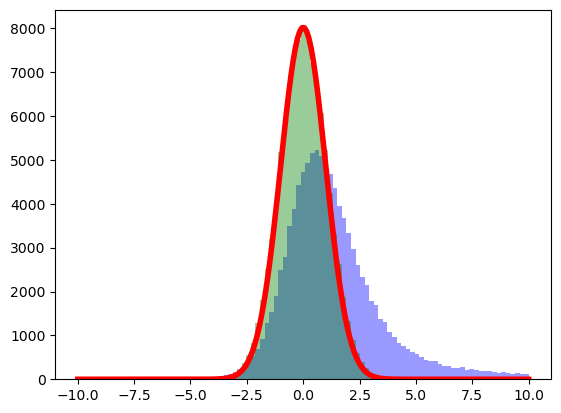

In [89]:
# for each photometry file, compute z-score

zscores = []
zscores_cntl = []
for i in range(phot_deep.shape[0]):
    
    # match tractor ID
    idx_match = np.where(COSMOS_tab['Tractor_ID']==phot_deep[i][0])[0][0]
    
    zscore = (phot_deep[i][3::2] - sed102[idx_match][3:]) / phot_deep[i][4::2]
    zscores.append(zscore)
    
    zscore_cntl = (phot_deep_cntl[i][3::2] - sed102[idx_match][3:]) / phot_deep_cntl[i][4::2]
    zscores_cntl.append(zscore_cntl)

zscores = np.array(zscores)
zscores_cntl = np.array(zscores_cntl)



hist = plt.hist(zscores.flatten(), bins=np.linspace(-10,10,100), 
                alpha=0.4, color='blue')[0];

hist = plt.hist(zscores_cntl.flatten(), bins=np.linspace(-10,10,100), 
                alpha=0.4, color='green')[0];


def Gaussian(x, A, sig, x0):
    g = A * np.exp(-(x-x0)**2 / (2*sig**2))
    return g

xx = np.linspace(-10, 10, 200)
plt.plot(xx, Gaussian(xx, hist.max(), 1, 0), color='red', lw=4)


### Check photo-z output - confusion injection

In [215]:
## load in photo-z output tables

# deep field outputs
confusion_lib = True # whether or not use injected confusion or full photometric simulation

if confusion_lib is True:
    tab_deep_lib = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/photoz/outfiles/secondary_cosmos1k_deep_deepfield_dz0.002_confinj_half.out")
# else:
#     tab_deep = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/photoz/outfiles/secondary_cosmos1k_deep_deepfield_dz0.002.out")

# controlled run with no confusion
tab_deep_cntl = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/photoz/outfiles/secondary_cosmos1k_deep_deepfield_dz0.002_cntl.out")

# tab_all = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/photoz/outfiles/secondary_cosmos1k_deep_allsky_dz0.002.out")
# tab_all_cntl = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/photoz/outfiles/secondary_cosmos1k_deep_allsky_dz0.002_cntl.out")


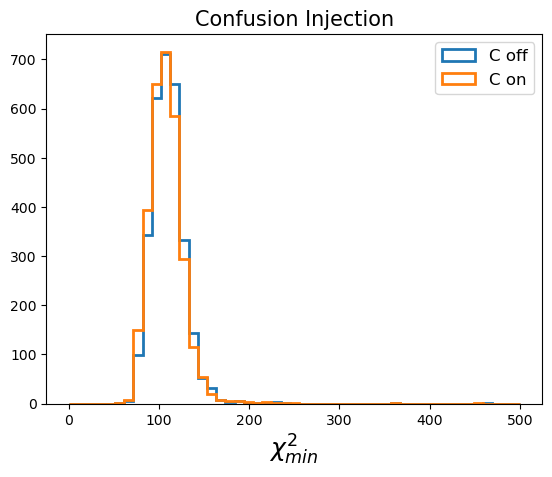

In [216]:
## check chi^2 distribution
plt.hist(tab_deep_cntl['minchi2_minchi2'], bins=np.linspace(0, 500, 50), histtype='step', lw=2, label='C off')
plt.hist(tab_deep_lib['minchi2_minchi2'], bins=np.linspace(0, 500, 50), histtype='step', lw=2, label='C on')
plt.xlabel(r"$\chi^2_{min}$", fontsize=18)
plt.legend(fontsize=12)
if confusion_lib is True:
    plt.title("Confusion Injection", fontsize=15)
else:
    plt.title("Full Photometry Run w/ Confusion", fontsize=15)

/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_1437/2402326341.py:18: UserWarning: Warning: converting a masked element to nan.
  hist_z_cntl = plt.hist(np.array(zscores_z_cntl)[cut_cntl], bins=np.linspace(-10, 10, 50),
/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_1437/2402326341.py:20: UserWarning: Warning: converting a masked element to nan.
  hist_z = plt.hist(np.array(zscores_z)[cut], bins=np.linspace(-10,10,50),


Text(0.5, 0, 'Redshift z-score')

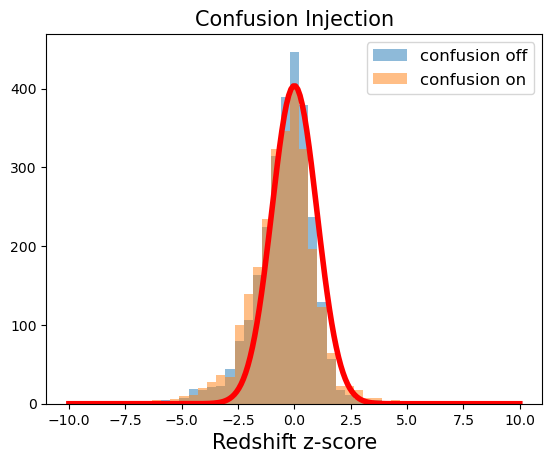

In [217]:
## check redshift z-score

# controlled run, no confusion
cut_cntl = (tab_deep_cntl['z_err_std'] / (1 + tab_deep_cntl['z_best'])) <= 0.2
zscores_z_cntl = []

# with confusion
cut = (tab_deep_lib['z_err_std'] / (1 + tab_deep_lib['z_best'])) <= 0.2
zscores_z = []

for i in range(len(tab_deep_cntl)):
    
    # match tractor ID
    idx_match = np.where(COSMOS_tab['Tractor_ID']==tab_deep_cntl['id'][i])[0][0]
    zscores_z_cntl.append((tab_deep_cntl['z_best'][i] - COSMOS_tab['lp_zBEST'][idx_match]) / tab_deep_cntl['z_err_std'][i])
    zscores_z.append((tab_deep_lib['z_best'][i] - COSMOS_tab['lp_zBEST'][idx_match]) / tab_deep_lib['z_err_std'][i])
    
hist_z_cntl = plt.hist(np.array(zscores_z_cntl)[cut_cntl], bins=np.linspace(-10, 10, 50), 
                       alpha=0.5, label='confusion off')[0]
hist_z = plt.hist(np.array(zscores_z)[cut], bins=np.linspace(-10,10,50), 
                  alpha=0.5, label='confusion on')[0]
xx = np.linspace(-10, 10, 200)
plt.legend(fontsize=12)

if confusion_lib is True:
    plt.title("Confusion Injection", fontsize=15)
else:
    plt.title("Full Photometric Run with Confusion", fontsize=15)
    
plt.plot(xx, Gaussian(xx, hist_z.max(), 1, 0), color='red', lw=4)
plt.xlabel("Redshift z-score", fontsize=15)

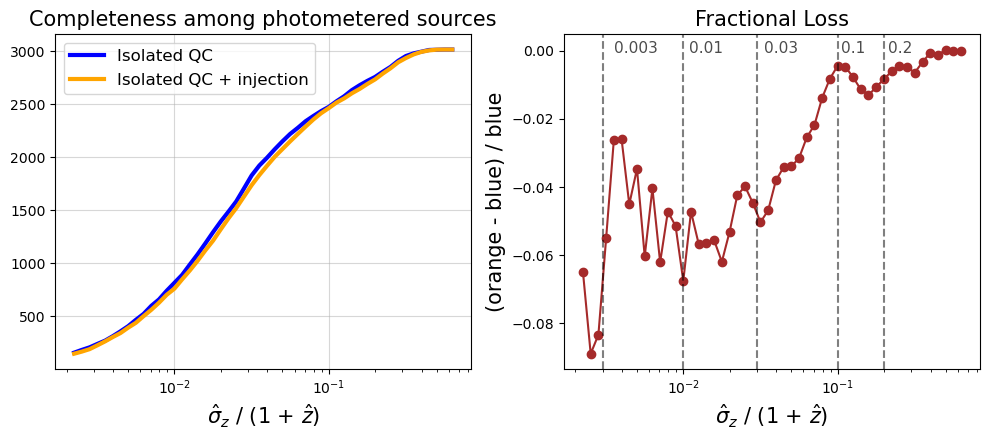

In [218]:
## plot cumulative number of sources below given redshift errors

# pick bins for reported redshift errors

z_err_bins = np.logspace(-2.65, -0.2, 50)
Nsrcs_cntl = []
Nsrcs_lib = []
# calculate 
for bins in z_err_bins:

    z_errs_cntl = tab_deep_cntl['z_err_std'] / (1 + tab_deep_cntl['z_best'])
    Nsrcs_cntl.append(len(np.where(z_errs_cntl <= bins)[0]))
    
    z_errs = tab_deep_lib['z_err_std'] / (1 + tab_deep_lib['z_best'])
    Nsrcs_lib.append(len(np.where(z_errs <= bins)[0]))

Nsrcs_lib = np.array(Nsrcs_lib)
Nsrcs_cntl = np.array(Nsrcs_cntl)
    
fig = plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.plot(z_err_bins, Nsrcs_cntl , color='blue', lw=3, label='Isolated QC')
plt.plot(z_err_bins, Nsrcs_lib , color='orange', lw=3, label='Isolated QC + injection')
plt.xscale("log")
plt.xlabel(r"$\hat{\sigma}_z$ / (1 + $\hat{z}$)", fontsize=15)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.title("Completeness among photometered sources", fontsize=15)
# plt.text(0.05, 0.95, r'$\tilde{{\sigma}}_{{z/(1+z)}}$ = {:.4f}'.format(gaussian_sig), transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.subplot(1,2,2)
plt.plot(z_err_bins, (Nsrcs_lib-Nsrcs_cntl) / Nsrcs_cntl, color='brown', marker='o')
plt.xscale("log")
plt.ylabel("(orange - blue) / blue", fontsize=15)
plt.title("Fractional Loss", fontsize=15)
plt.xlabel(r"$\hat{\sigma}_z$ / (1 + $\hat{z}$)", fontsize=15)
plt.axvline(0.003, color='black', ls='--', alpha=0.5)
plt.text(0.12, 0.98, '0.003', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.01, color='black', ls='--', alpha=0.5)
plt.text(0.3, 0.98, '0.01', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.03, color='black', ls='--', alpha=0.5)
plt.text(0.48, 0.98, '0.03', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.1, color='black', ls='--', alpha=0.5)
plt.text(0.665, 0.98, '0.1', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.2, color='black', ls='--', alpha=0.5)
plt.text(0.78, 0.98, '0.2', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

fig.tight_layout()

plt.show()



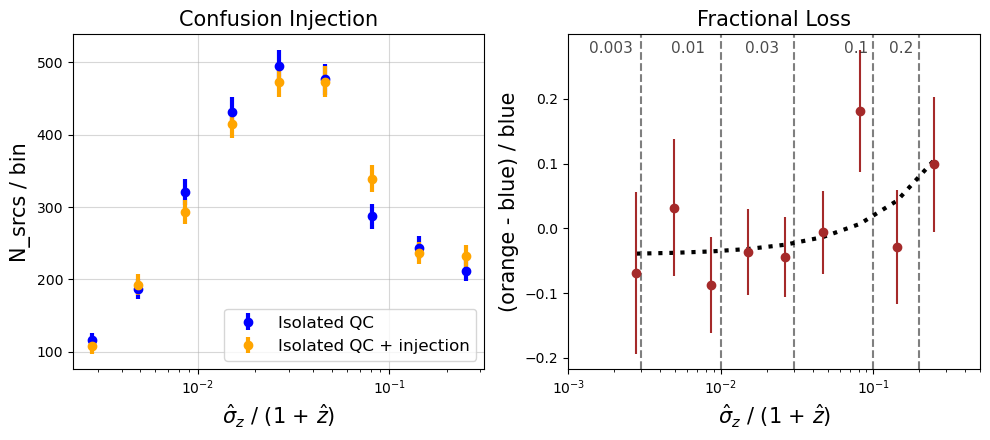

In [219]:
## N sources per redshift error bin, non-cumulative, with ERROR BARS!

# z_err_bins = np.array([0.001, 0.003, 0.005, 0.01, 0.03, 0.06, 0.1, 0.15, 0.2])
z_err_bins = np.logspace(-2.8, -0.6, 10)
# z_err_bins = np.array([1e-5, 0.003, 0.01, 0.03, 0.1, 0.2])

Nsrcs_cntl = []
Nsrcs_lib = []
# calculate 
for i, bins in enumerate(z_err_bins[1:]):

    Nsrcs_cntl.append(len(np.where((z_errs_cntl < bins) & (z_errs_cntl >=z_err_bins[i]))[0]))
    
    Nsrcs_lib.append(len(np.where((z_errs < bins) & (z_errs >=z_err_bins[i]))[0]))

Nsrcs_lib = np.array(Nsrcs_lib)
Nsrcs_cntl = np.array(Nsrcs_cntl)
dN_lib = np.sqrt(Nsrcs_lib) # uncertainty
dN_cntl = np.sqrt(Nsrcs_cntl) # uncertainty

# plot 
fig = plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)

plt.errorbar(z_err_bins[1:], Nsrcs_cntl, yerr=dN_cntl, 
             fmt='o', color='blue', lw=3, label='Isolated QC')

plt.errorbar(z_err_bins[1:], Nsrcs_lib, yerr=dN_lib,
             fmt='o', color='orange', lw=3, label='Isolated QC + injection')

plt.xscale("log")
plt.xlabel(r"$\hat{\sigma}_z$ / (1 + $\hat{z}$)", fontsize=15)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
# plt.title("Completeness among photometered sources", fontsize=15)
plt.ylabel("N_srcs / bin", fontsize=15)
if confusion_lib is True:
    plt.title("Confusion Injection", fontsize=15)
else:
    plt.title("Full Photometry Run w/ Confusion", fontsize=15)
# plt.text(0.05, 0.95, r'$\tilde{{\sigma}}_{{z/(1+z)}}$ = {:.4f}'.format(gaussian_sig), transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.subplot(1,2,2)

d_Nfrac_lib = np.sqrt((dN_lib / Nsrcs_cntl)**2 + (Nsrcs_lib*dN_cntl / Nsrcs_cntl**2)**2)
loss_lib = (Nsrcs_lib-Nsrcs_cntl) / Nsrcs_cntl

## fit a linear or quadratic curve
def fit_curve_linear(sigma_z, a, b):
    loss = a * sigma_z + b
    return loss
def fit_curve_quad(sigma_z, a, b, c):
    loss = a * sigma_z**2 + b * sigma_z + c
    return loss
(fit_lib, err_lib) = opt.curve_fit(fit_curve_linear, z_err_bins[1:], loss_lib, sigma=d_Nfrac_lib)
plt.plot(z_err_bins[1:], fit_curve_linear(z_err_bins[1:], fit_lib[0], fit_lib[1]), color='black', ls=':', lw=3)

plt.errorbar(z_err_bins[1:], loss_lib, yerr=d_Nfrac_lib, 
             color='brown', fmt='o')
plt.xscale("log")
plt.ylabel("(orange - blue) / blue", fontsize=15)
plt.title("Fractional Loss", fontsize=15)
plt.xlabel(r"$\hat{\sigma}_z$ / (1 + $\hat{z}$)", fontsize=15)
plt.axvline(0.003, color='black', ls='--', alpha=0.5)
plt.text(0.05, 0.98, '0.003', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.01, color='black', ls='--', alpha=0.5)
plt.text(0.25, 0.98, '0.01', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.03, color='black', ls='--', alpha=0.5)
plt.text(0.43, 0.98, '0.03', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.1, color='black', ls='--', alpha=0.5)
plt.text(0.67, 0.98, '0.1', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.2, color='black', ls='--', alpha=0.5)
plt.text(0.78, 0.98, '0.2', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

fig.tight_layout()
plt.xlim(0.001, 0.5)

plt.show()



Error propagation:

Given $N_1 \pm \delta N_1$ and $N_2 \pm \delta N_2$, uncertainty on $\frac{N_1 - N_2}{N_2}$ is 
$$ \sqrt{\left(\frac{\delta N_1}{ N_2}\right)^2 + \left(\frac{N_1}{ N_2^2}\delta N_2\right)^2}.$$

### Check Photo-z output - full confusion photometry

In [220]:
## load in photo-z output tables

# deep field outputs

tab_deep_qc = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/photoz/outfiles/secondary_cosmos1k_deep_deepfield_dz0.002.out")

# controlled run with no confusion
tab_deep_cntl = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/photoz/outfiles/secondary_cosmos1k_deep_deepfield_dz0.002_cntl.out")


/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_1437/175526974.py:18: UserWarning: Warning: converting a masked element to nan.
  hist_z_cntl = plt.hist(np.array(zscores_z_cntl)[cut_cntl], bins=np.linspace(-10, 10, 50),
/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_1437/175526974.py:20: UserWarning: Warning: converting a masked element to nan.
  hist_z = plt.hist(np.array(zscores_z)[cut], bins=np.linspace(-10,10,50),


Text(0.5, 0, 'Redshift z-score')

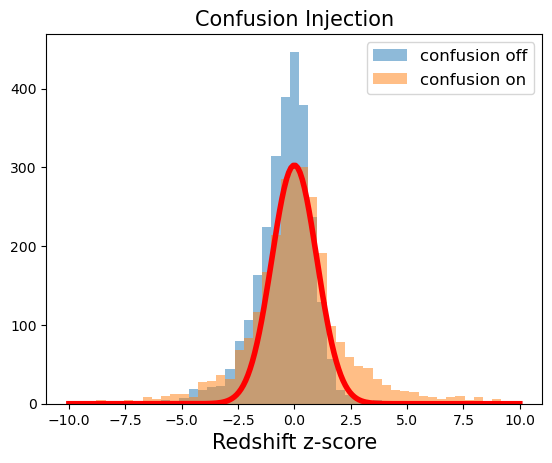

In [221]:
## check redshift z-score

# controlled run, no confusion
cut_cntl = (tab_deep_cntl['z_err_std'] / (1 + tab_deep_cntl['z_best'])) <= 0.2
zscores_z_cntl = []

# with confusion
cut = (tab_deep_qc['z_err_std'] / (1 + tab_deep_qc['z_best'])) <= 0.2
zscores_z = []

for i in range(len(tab_deep_cntl)):
    
    # match tractor ID
    idx_match = np.where(COSMOS_tab['Tractor_ID']==tab_deep_cntl['id'][i])[0][0]
    zscores_z_cntl.append((tab_deep_cntl['z_best'][i] - COSMOS_tab['lp_zBEST'][idx_match]) / tab_deep_cntl['z_err_std'][i])
    zscores_z.append((tab_deep_qc['z_best'][i] - COSMOS_tab['lp_zBEST'][idx_match]) / tab_deep_qc['z_err_std'][i])
    
hist_z_cntl = plt.hist(np.array(zscores_z_cntl)[cut_cntl], bins=np.linspace(-10, 10, 50), 
                       alpha=0.5, label='confusion off')[0]
hist_z = plt.hist(np.array(zscores_z)[cut], bins=np.linspace(-10,10,50), 
                  alpha=0.5, label='confusion on')[0]
xx = np.linspace(-10, 10, 200)
plt.legend(fontsize=12)

if confusion_lib is True:
    plt.title("Confusion Injection", fontsize=15)
else:
    plt.title("Full Photometric Run with Confusion", fontsize=15)
    
plt.plot(xx, Gaussian(xx, hist_z.max(), 1, 0), color='red', lw=4)
plt.xlabel("Redshift z-score", fontsize=15)

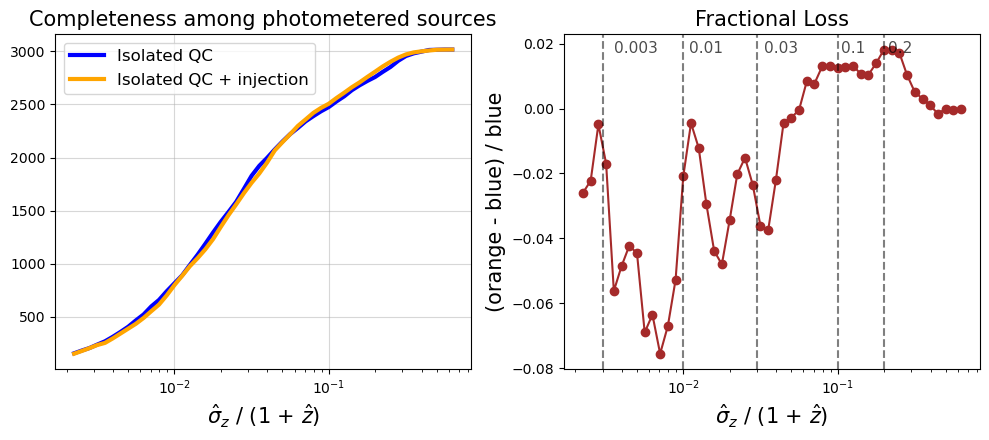

In [222]:
## plot cumulative number of sources below given redshift errors

# pick bins for reported redshift errors

z_err_bins = np.logspace(-2.65, -0.2, 50)
Nsrcs_cntl = []
Nsrcs_qc = []
# calculate 
for bins in z_err_bins:

    z_errs_cntl = tab_deep_cntl['z_err_std'] / (1 + tab_deep_cntl['z_best'])
    Nsrcs_cntl.append(len(np.where(z_errs_cntl <= bins)[0]))
    
    z_errs = tab_deep_qc['z_err_std'] / (1 + tab_deep_qc['z_best'])
    Nsrcs_qc.append(len(np.where(z_errs <= bins)[0]))

Nsrcs_qc = np.array(Nsrcs_qc)
Nsrcs_cntl = np.array(Nsrcs_cntl)
    
fig = plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.plot(z_err_bins, Nsrcs_cntl , color='blue', lw=3, label='Isolated QC')
plt.plot(z_err_bins, Nsrcs_qc , color='orange', lw=3, label='Isolated QC + injection')
plt.xscale("log")
plt.xlabel(r"$\hat{\sigma}_z$ / (1 + $\hat{z}$)", fontsize=15)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.title("Completeness among photometered sources", fontsize=15)
# plt.text(0.05, 0.95, r'$\tilde{{\sigma}}_{{z/(1+z)}}$ = {:.4f}'.format(gaussian_sig), transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.subplot(1,2,2)
plt.plot(z_err_bins, (Nsrcs_qc-Nsrcs_cntl) / Nsrcs_cntl, color='brown', marker='o')
plt.xscale("log")
plt.ylabel("(orange - blue) / blue", fontsize=15)
plt.title("Fractional Loss", fontsize=15)
plt.xlabel(r"$\hat{\sigma}_z$ / (1 + $\hat{z}$)", fontsize=15)
plt.axvline(0.003, color='black', ls='--', alpha=0.5)
plt.text(0.12, 0.98, '0.003', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.01, color='black', ls='--', alpha=0.5)
plt.text(0.3, 0.98, '0.01', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.03, color='black', ls='--', alpha=0.5)
plt.text(0.48, 0.98, '0.03', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.1, color='black', ls='--', alpha=0.5)
plt.text(0.665, 0.98, '0.1', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.2, color='black', ls='--', alpha=0.5)
plt.text(0.78, 0.98, '0.2', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

fig.tight_layout()

plt.show()



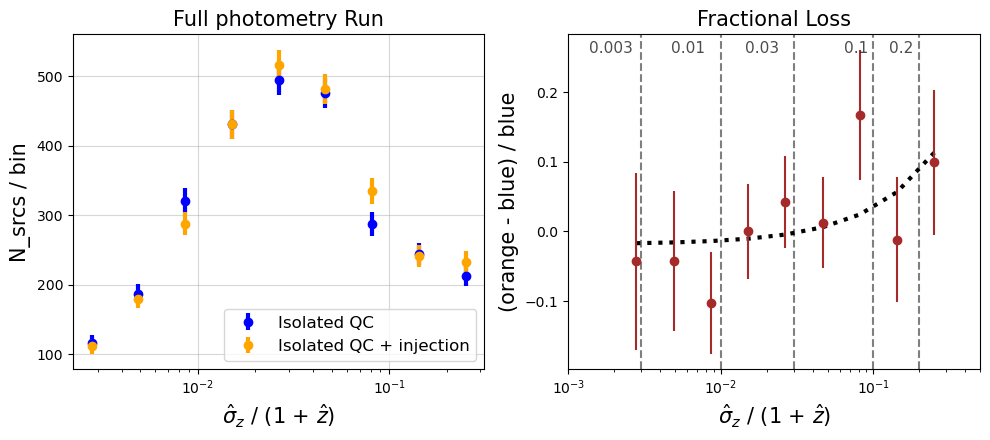

In [223]:
## N sources per redshift error bin, non-cumulative, with ERROR BARS!

# z_err_bins = np.array([0.001, 0.003, 0.005, 0.01, 0.03, 0.06, 0.1, 0.15, 0.2])
z_err_bins = np.logspace(-2.8, -0.6, 10)
# z_err_bins = np.array([1e-5, 0.003, 0.01, 0.03, 0.1, 0.2])

Nsrcs_cntl = []
Nsrcs_qc = []
# calculate 
for i, bins in enumerate(z_err_bins[1:]):

    Nsrcs_cntl.append(len(np.where((z_errs_cntl < bins) & (z_errs_cntl >=z_err_bins[i]))[0]))
    
    Nsrcs_qc.append(len(np.where((z_errs < bins) & (z_errs >=z_err_bins[i]))[0]))

Nsrcs_qc = np.array(Nsrcs_qc)
Nsrcs_cntl = np.array(Nsrcs_cntl)
dN_qc = np.sqrt(Nsrcs_qc) # uncertainty
dN_cntl = np.sqrt(Nsrcs_cntl) # uncertainty

# plot 
fig = plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)

plt.errorbar(z_err_bins[1:], Nsrcs_cntl, yerr=dN_cntl, 
             fmt='o', color='blue', lw=3, label='Isolated QC')

plt.errorbar(z_err_bins[1:], Nsrcs_qc, yerr=dN_qc,
             fmt='o', color='orange', lw=3, label='Isolated QC + injection')

plt.xscale("log")
plt.xlabel(r"$\hat{\sigma}_z$ / (1 + $\hat{z}$)", fontsize=15)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
# plt.title("Completeness among photometered sources", fontsize=15)
plt.ylabel("N_srcs / bin", fontsize=15)
plt.title("Full photometry Run", fontsize=15)
# plt.text(0.05, 0.95, r'$\tilde{{\sigma}}_{{z/(1+z)}}$ = {:.4f}'.format(gaussian_sig), transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.subplot(1,2,2)

d_Nfrac_qc = np.sqrt((dN_qc / Nsrcs_cntl)**2 + (Nsrcs_qc*dN_cntl / Nsrcs_cntl**2)**2)
loss_qc = (Nsrcs_qc-Nsrcs_cntl) / Nsrcs_cntl
(fit_qc, err_qc) = opt.curve_fit(fit_curve_linear, z_err_bins[1:], loss_qc, sigma=d_Nfrac_qc)
plt.plot(z_err_bins[1:], fit_curve_linear(z_err_bins[1:], fit_qc[0], fit_qc[1]), color='black', ls=':', lw=3)

plt.errorbar(z_err_bins[1:], loss_qc, yerr=d_Nfrac_qc, 
             color='brown', fmt='o')
plt.xscale("log")
plt.ylabel("(orange - blue) / blue", fontsize=15)
plt.title("Fractional Loss", fontsize=15)
plt.xlabel(r"$\hat{\sigma}_z$ / (1 + $\hat{z}$)", fontsize=15)
plt.axvline(0.003, color='black', ls='--', alpha=0.5)
plt.text(0.05, 0.98, '0.003', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.01, color='black', ls='--', alpha=0.5)
plt.text(0.25, 0.98, '0.01', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.03, color='black', ls='--', alpha=0.5)
plt.text(0.43, 0.98, '0.03', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.1, color='black', ls='--', alpha=0.5)
plt.text(0.67, 0.98, '0.1', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

plt.axvline(0.2, color='black', ls='--', alpha=0.5)
plt.text(0.78, 0.98, '0.2', transform=plt.gca().transAxes, fontsize=11, alpha=0.7, verticalalignment='top')

fig.tight_layout()
plt.xlim(0.001, 0.5)

plt.show()



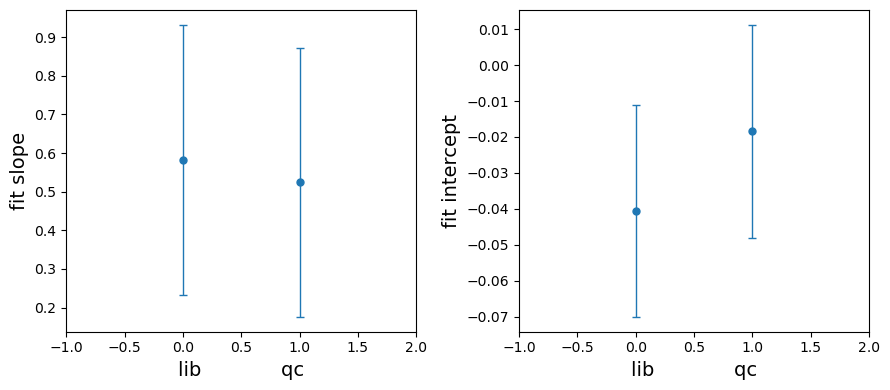

In [225]:
## compare the fits

fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.errorbar([0,1], [fit_lib[0], fit_qc[0]], yerr=[np.sqrt(err_lib[0,0]), np.sqrt(err_qc[0,0])],
             fmt='o', capsize=3, lw=1, ms=5)
plt.xlim(-1,2)
plt.xlabel("lib             qc", fontsize=14)
plt.ylabel("fit slope", fontsize=14)

plt.subplot(1,2,2)
plt.errorbar([0,1], [fit_lib[1], fit_qc[1]], yerr=[np.sqrt(err_lib[1,1]), np.sqrt(err_qc[1,1])],
             fmt='o', capsize=3, lw=1, ms=5)
plt.xlim(-1,2)
plt.xlabel("lib             qc", fontsize=14)
plt.ylabel("fit intercept", fontsize=14)

fig.tight_layout()

### Statistical consistency test

$\chi^2$ test - like testing deviation of {$x_i$} from {$y_i$}: $$\chi^2 = \sum_{i} \frac{(x_i - y_i)^2}{\sigma_{x,i}^2 + \sigma_{y,i}^2}$$

In [200]:
### chi^2 tests
from scipy.stats import chi2

# from fractional loss
# chi_sq = np.sum((loss_lib - loss_qc)**2 / (d_Nfrac_lib**2 + d_Nfrac_qc**2))

# from number counts
chi_sq = np.sum((Nsrcs_lib - Nsrcs_qc)**2 / (dN_lib**2 + dN_qc**2))

dof = len(loss_lib)
chi_sq_red = chi_sq / dof
print("reduced chi^2 = ", chi_sq_red)

p_value = 1 - chi2.cdf(chi_sq, dof)
print('p-value = ', p_value)


reduced chi^2 =  0.7571446782654455
p-value =  0.6234024830138593


### Plotting stuff

In [400]:
sed0 = Table.read("../../../../SPHEREx_2023/COSMOS2020_Zero_Spec.fits", format='fits')

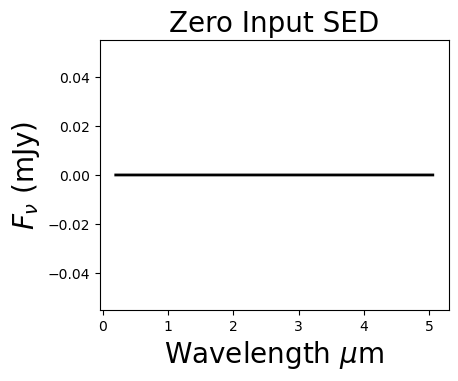

In [417]:
plt.figure(figsize=(4.5,3.5))
plt.plot(sed0['lambda'], sed0['FLUX'], color='black', lw=2)
plt.xlabel(r"Wavelength $\mu$m", fontsize=20)
plt.ylabel(r"$F_{\nu}$ (mJy)", fontsize=20)
plt.title("Zero Input SED", fontsize=20)
plt.savefig("../../../figures/zero_spectrum.png", dpi=400, bbox_inches='tight')

(1998, 208)


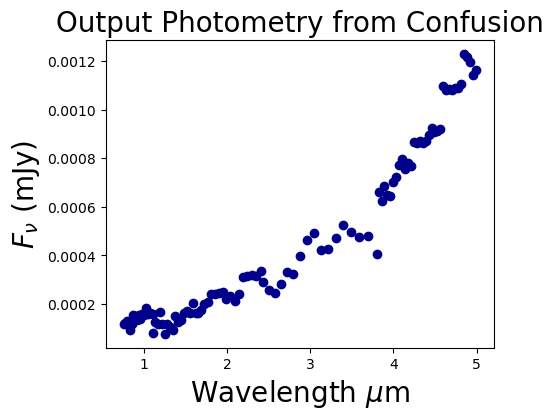

In [439]:
sed_confusion = np.loadtxt("../../../data/QCdata_N2000_Pix10_updatedJan2025_new32krefcat.txt")
print(sed_confusion.shape)

plt.figure(figsize=(5, 4))
plt.errorbar(wl, sed_confusion[5][4::2], yerr=sed_confusion[5][5::2], fmt='o', color='darkblue')
plt.xlabel(r"Wavelength $\mu$m", fontsize=20)
plt.ylabel(r"$F_{\nu}$ (mJy)", fontsize=20)
plt.title("Output Photometry from Confusion", fontsize=20)
plt.savefig("../../../figures/output_confusion_spectrum.png", dpi=400, bbox_inches='tight')

# Deep Field Selection: full confusion run


## Jean's isolated run

In [264]:
# photoz input catalog
pz = "../data/pz_Jean.txt"
pz = np.loadtxt(pz)

# photoz output table with ref cat (full-sky + deep-field)
tab = "../data/xmatch_deep_field_photoz.fits"
tab = Table.read(tab, format='fits')

print(tab.keys())
print(len(tab))

['SPHERExRefID', 'LegacySurvey_uid', 'ra', 'dec', 'ra_error', 'dec_error', 'Gaia_G', 'LS_g', 'LS_r', 'LS_z', 'LS_g_error', 'LS_r_error', 'LS_z_error', 'LS_type', 'flag_blending', 'flag_brightneighbor', 'dist_nearest', 'class', 'spherex_class', 'z', 'z_err', 'z_dup', 'z_survey', 'z_ID', 'LS_W1', 'LS_W2', 'LS_W1_err', 'LS_W2_err', 'fiberflux_g', 'fiberflux_r', 'fiberflux_z', 'fibertotflux_g', 'fibertotflux_r', 'fibertotflux_z', 'nobs_g', 'nobs_r', 'nobs_z', 'nobs_w1', 'nobs_w2', 'Tractor_ID', 'redshift', 'z_best', 'z_med', 'z_err_std', 'z_err_l68', 'z_err_u68', 'skewness', 'kurtosis', 'minchi2_minchi2', 'z_minchi2', 'loge_density_minchi2', 'mod_minchi2', 'extlaw_minchi2', 'ebv_minchi2', 'scale_minchi2', 'loge_pdfsum', 'z_pdfmax', 'loge_density_pdfmax', 'minchi2_pdfmax', 'mod_pdfmax', 'extlaw_pdfmax', 'ebv_pdfmax', 'scale_pdfmax', 'snr_per_filter', 'ra_deep', 'dec_deep', 'z_best_deep', 'z_med_deep', 'z_err_std_deep', 'z_err_l68_deep', 'z_err_u68_deep', 'skewness_deep', 'kurtosis_deep', 'm

In [258]:

## functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import scipy as sp
import pickle 
import random
from scipy import optimize as opt
from astropy.io import fits
from astropy.table import Table, Column, vstack, hstack
import pyarrow.parquet as pq
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde


# ---------------------------------------------
## functions

def calc_cuts(colors_good, colors_bad):
    
    """
    Inputs: 
    colors_good = z-mag, and z-w1 of sources that have sigma_z/1+z < threshold value; 
                  a list of two arrays
    colors_bad  = z-mag, and z-w1 of sources that have sigma_z/1+z > threshold value; 
                  a list of two arrays
    
    -----------
    What does it do? 
    
    - In short, it uses a logistic regression model to calculate boundaries between the two populations
    
    - Specifically, given input parameters, z-mag and z-w1 color, a logistic function is used to 
      to map from these parameters to probability (0, 1] of a data point belonging to a particular class.
      
       - Inputs are linearly combined into z = w1*x1 + w2*x2 + b where x1, x2 are inputs and w1, w2 are the 
         weights learned by the model, and b is the bias term. 
         
       - Then z is passed through the sigmoid (logistic) function to convert it into a probability 
         P(y=1 | x) = sigma(z) \propto 1 / (1 + exp(x)). 
         
       - The weights are learned and optimized by going along the direction of the fastest loss gradient
         (slope change), until it reaches a minimum loss. 
        
       - Finally, using these optimized weights, it assigns probability of data points that belong to the 
         "bad" class. 
    
    - Eventually, the various contour levels represent the probability of sources belonging to the bad class.
    
    For more details, see section 3: Calculate Decision Boundaries
    
    """
    
    # parse "good" and "bad" populaitons on the color-magnitude space
    (cl_x_good, cl_y_good) = colors_good
    (cl_x_bad, cl_y_bad) = colors_bad
    
    # keep only finite values
    good_mask = np.isfinite(cl_x_good) & np.isfinite(cl_y_good)
    bad_mask = np.isfinite(cl_x_bad) & np.isfinite(cl_y_bad)
    
    # Combine good and bad populations into a single dataset
    X_good = np.vstack((cl_x_good[good_mask], cl_y_good[good_mask])).T
    X_bad = np.vstack((cl_x_bad[bad_mask], cl_y_bad[bad_mask])).T
    X = np.vstack((X_good, X_bad))
    y = np.hstack((np.zeros(X_good.shape[0]), np.ones(X_bad.shape[0])))  # 0: good, 1: bad

    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # standardize the data for betater performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # train a Logistic Regression classifier
    clf = LogisticRegression()
    clf.fit(X_train_scaled, y_train)

    # generate probability contours instead of hard decision boundaries
    # create a mesh grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 2
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    
    # predict probabilities on the mesh grid
    probs = clf.predict_proba(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))[:, 1].reshape(xx.shape)  

    return xx, yy, probs


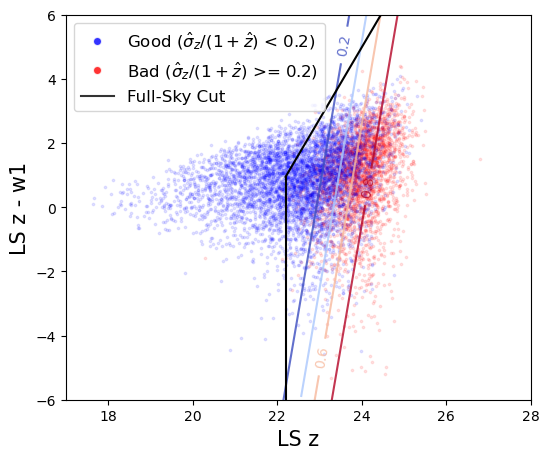

In [259]:
def get_mag_from_flux(flux_Jy):
    mag = -2.5 * np.log10(flux_Jy / 3631)
    return mag

mag_w1 = get_mag_from_flux(tab['LS_W1'] / 1e6)
mag_z  = get_mag_from_flux(tab['LS_z']  / 1e6)

cl_x = mag_z
cl_y = mag_z - mag_w1
sig_z = tab['z_err_std_deep'] / (1 + tab['z_best_deep'])
# plt.scatter(cl_x, cl_y, s=1, c=sig_z)
# cbar = plt.colorbar()
# cbar.set_label(r"$\hat{\sigma}_z$ / (1 + $\hat{z}$)")


## define contour cuts
# choose a sigma_z/1+z cut, we want to be conservative here
cut = 0.2

cut_good = (sig_z <= cut)
cut_bad = (sig_z > cut)

cl_x_good = mag_z[cut_good]
cl_y_good = mag_z[cut_good] - mag_w1[cut_good]
cl_x_bad = mag_z[cut_bad]
cl_y_bad = mag_z[cut_bad] - mag_w1[cut_bad]


# train the boundaries
(xx, yy, probs1) = calc_cuts([cl_x_good,cl_y_good], [cl_x_bad, cl_y_bad])

# plot everything
plt.figure(figsize=(6, 5))

plt.scatter(cl_x_bad, cl_y_bad, color='red', alpha=0.1, s=3, label=r'Bad ($\hat{\sigma}_z/(1+\hat{z})$ >= 0.3)')
plt.scatter(cl_x_good, cl_y_good, color='blue', alpha=0.1, s=3, label=r'Good ($\hat{\sigma}_z/(1+\hat{z})$ < 0.3)')

# plot the decision boundary 
contour_levels = [0.2, 0.4, 0.6, 0.8] # probability contours
contour1 = plt.contour(xx, yy, probs1, levels=contour_levels, cmap="coolwarm", alpha=0.8)
plt.clabel(contour1, inline=True, fontsize=10, fmt='%1.1f')

x = np.linspace(22.2, np.nanmax(cl_x[np.isfinite(cl_x)]), 200)
plt.plot(x, 2.24 * x - 48.78, color='black')

xplot = [22.2] * 8
yplot = np.linspace(np.nanmin(cl_y[np.isfinite(cl_y)]), 2.24 * 22.2 - 48.78, len(xplot))
plt.plot(xplot, yplot, color='black', label='full-sky cut')
plt.legend(fontsize=12)

plt.xlim(17, 28)
plt.ylim(-6, 6)
plt.xlabel("LS z", fontsize=15)
plt.ylabel("LS z - w1", fontsize=15)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=r'Good ($\hat{\sigma}_z/(1+\hat{z})$ < 0.2)',
           markerfacecolor='blue', markersize=6, alpha=0.8),
    Line2D([0], [0], marker='o', color='w', label=r'Bad ($\hat{\sigma}_z/(1+\hat{z})$ >= 0.2)',
           markerfacecolor='red', markersize=6, alpha=0.8),
    Line2D([0], [0], color='black', label='Full-Sky Cut',
           markerfacecolor='w', markersize=6, alpha=0.8)
]

plt.legend(handles=legend_elements, loc='upper left', fontsize=12)


## Build confusion library given input catalog and color-mag cut

__confusion_lib_build.py__

__confusion_lib_run.py__


In [260]:
## generate the color-mag flag for a given contour

def boundary_LS(x, a, b):
    ### function to fit boundaries
    f = a*x+b
    return f
def calc_fit_contour(contours):
    
    ## function to fit a given contour line
    for ii, collection in enumerate(contours.collections):
        paths = collection.get_paths()
        for path in paths:
            vertices = path.vertices
            x_values = vertices[:, 0]
            y_values = vertices[:, 1]
    
    (fit, err) = opt.curve_fit(boundary_LS, x_values, y_values, absolute_sigma=True)
    return fit


[array([   7.70967805, -176.7730341 ]), array([   7.70968285, -179.891191  ]), array([   7.7096811 , -182.46922869]), array([   7.70966869, -185.58697078])]


/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_1437/2134989209.py:10: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for ii, collection in enumerate(contours.collections):


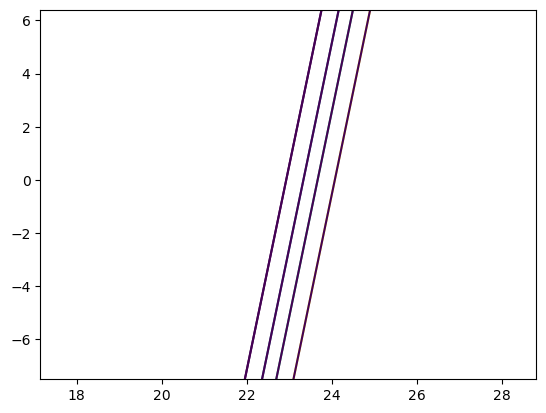

In [262]:
contour = plt.contour(xx, yy, probs1, levels=contour_levels)
Fit = []
for i, level in enumerate(contour_levels):
    contour = plt.contour(xx, yy, probs1, levels=[level])
    fits = calc_fit_contour(contour)
    Fit.append(fits)
print(Fit)

In [65]:
### given a color-magnitude cut, output the boolean array to a text file

# load the full cosmos catalog with LS fluxes
cosmos = Table.read("../../../../source_selection/COSMOS2020_SPHEXrefcat_v0.6_166k_withredshift_gemma_JAN2025.csv")

# compute magnitude for the full 166k
mag_w1 = get_mag_from_flux(cosmos['LS_W1'] / 1e6)
mag_z  = get_mag_from_flux(cosmos['LS_z']  / 1e6)

# select the cut for each contour

output_dir = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/refcat_cuts/"
for i, fit in enumerate(Fit):
    print(fit, "contour_percentage = ", contour_levels[i])
    
    flag = (mag_z - mag_w1) >= (fit[0] * mag_z + fit[1])
    print(len(flag))
    # write to an output file
    file_path = output_dir + f"boolean_cut_{contour_levels[i]}.txt"
    with open(file_path, 'w') as file:
        file.write(f"# color magnitude cut for contour percentage {contour_levels[i]*100} % \n")
        file.write(f"# (z-w1) >=  {fit[0]:.4f} * z + {fit[1]:.4f}\n")
        
        np.savetxt(file, flag, fmt='%d')
    



/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_89480/3708953998.py:2: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux_Jy / 3631)
/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_89480/3708953998.py:2: RuntimeWarning: divide by zero encountered in log10
  mag = -2.5 * np.log10(flux_Jy / 3631)


In [125]:
test = np.loadtxt(output_dir+"boolean_cut_0.2.txt", dtype=bool)
len(test)

166041

### Move COSMOS to deep field, add matching & flagging columns

In [58]:
## move the COSMOS center to the coordiantes Jean calculated

# Jean's selected catalog + photo-z
tab = "../data/xmatch_deep_field_photoz.fits"
tab = Table.read(tab, format='fits')
ra0 = tab['ra_deep'][0]
dec0 = tab['dec_deep'][0]

# full COSMOS 166k catalog
cosmos = Table.read("../../../../source_selection/COSMOS2020_SPHEXrefcat_v0.6_166k_withredshift_gemma_JAN2025.csv")

# match ID to Jean's selected 8k sources; need to append to the catalog
match_ID = np.isin(cosmos['Tractor_ID'], tab['Tractor_ID'])

# add the matching column to the full catalog
cosmos.add_column(match_ID, name='match', )

# transform COSMOS field center to deep field
ra_c = (cosmos['ra'].max() - cosmos['ra'].min()) / 2 + cosmos['ra'].min()
dec_c = (cosmos['dec'].max() - cosmos['dec'].min()) / 2 + cosmos['dec'].min()

# add the deep field coordinates to the full catalog
if "ra_deep" not in cosmos.colnames:
    cosmos.add_column((cosmos['ra'].copy() + (ra0 - ra_c)), name="ra_deep")
    cosmos.add_column((cosmos['dec'].copy() + (dec0 - dec_c)), name="dec_deep")

    
# plt.figure(figsize=(11,5))
# plt.subplot(1,2,1)
# plt.scatter(cosmos['ra_deep'], cosmos['dec_deep'], s=1)
# plt.xlabel("RA")
# plt.ylabel("DEC")


array([False, False, False, ..., False,  True, False])

In [65]:
## output the full catalog

cosmos.write("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/refcat_cuts/COSMOS2020_SPHEXrefcat_v0.6_166k_matched_Jean8k.csv")


In [109]:
cosmos = Table.read("/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/refcat_cuts/COSMOS2020_SPHEXrefcat_v0.6_166k_matched_Jean8k.csv")

In [115]:
cosmos['match']

'False'

In [118]:
rand = np.random.randint(low=0, high=1000, size=100)
match = cosmos['match'] == 'True'
len(rand), len(cosmos[match])

(100, 7795)

In [137]:
path = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/deep-field-phot-on-maps/data/test.parq"
test = path.split("/")

In [147]:
pp = os.path.join('/', test[1])
for p in test[2:-1]:
    print(p)
    pp = os.path.join(pp, p)

gemmahuai
Desktop
CalTech
SPHEREx
Redshift
deep_field
deep-field-phot-on-maps
data


## Blended photometry QC + Tractor: test_survey_plan.ipynb

In [15]:
## check output from run_QC_blended.py

out = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/deep_field/data/blended_QC/test_combined.parq"
out = Table.read(out)


<ErrorbarContainer object of 3 artists>

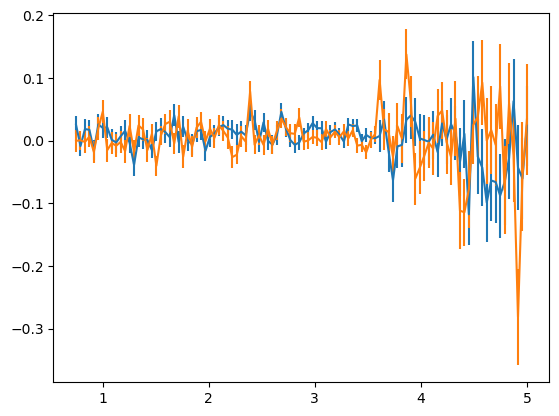

In [13]:
wl = np.linspace(0.75, 5.0, 102) # for temporary approximated channels
plt.errorbar(wl, out[0][3::2], out[0][4::2])
plt.errorbar(wl, out[1][3::2], out[1][4::2])

## Photo-z output

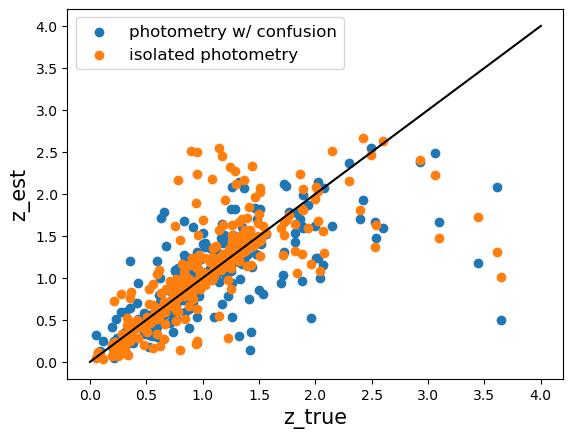

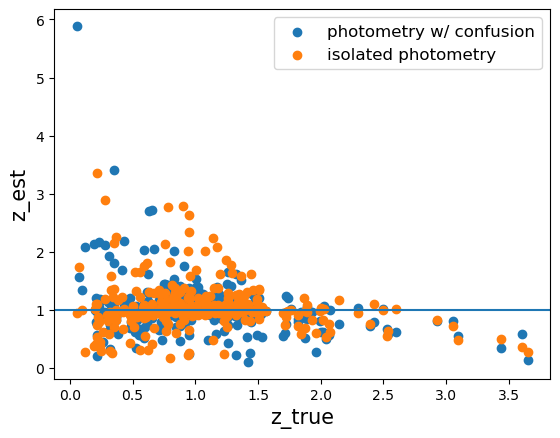

Text(0.5, 0, '$(\\hat{z} - z_{in}) / \\hat{\\sigma}_z$')

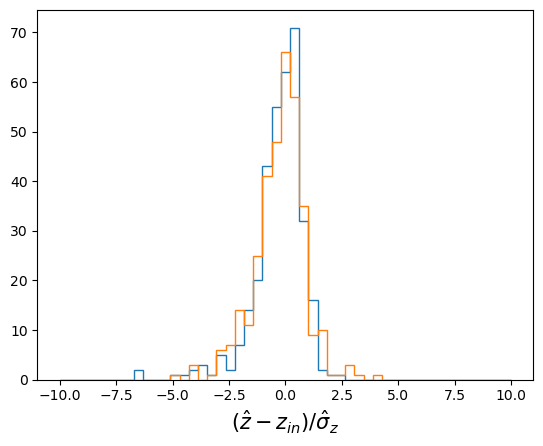

In [254]:
photz_04 = Table.read("../data/outfiles/secondary_combined_photoz_withAri_0.4.out")
## cross match to Jean's 
match_idx = np.isin(tab['Tractor_ID'], photz_04['id'])

plt.scatter(tab['redshift'][match_idx], photz_04['z_best'], label='photometry w/ confusion')
plt.scatter(tab['redshift'][match_idx], tab['z_best_deep'][match_idx], label='isolated photometry')
plt.plot(np.linspace(0, 4, 20), np.linspace(0, 4, 20), color='black')
plt.xlabel("z_true", fontsize=15)
plt.ylabel("z_est", fontsize=15)
plt.legend(fontsize=12)
plt.show()

plt.scatter(tab['redshift'][match_idx], photz_04['z_best']/tab['redshift'][match_idx], label='photometry w/ confusion')
plt.scatter(tab['redshift'][match_idx], tab['z_best_deep'][match_idx]/tab['redshift'][match_idx], label='isolated photometry')
plt.axhline(1)
plt.xlabel("z_true", fontsize=15)
plt.ylabel("z_est", fontsize=15)
plt.legend(fontsize=12)
plt.show()


## compare z-score
bins = np.linspace(-10,10,50)
plt.hist((photz_04['z_best'] - tab['redshift'][match_idx]) / photz_04['z_err_std'], 
        bins=bins, histtype='step')
plt.hist((tab['z_best_deep'][match_idx] - tab['redshift'][match_idx]) / tab['z_err_std_deep'][match_idx], 
        bins=bins, histtype='step')
plt.xlabel(r"$(\hat{z} - z_{in}) / \hat{\sigma}_z$", fontsize=15)
